In [340]:
### Data Manipulation and Analysis
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical operations and array handling

### Data Visualization
import matplotlib.pyplot as plt  # Data visualization and plotting

### Statistical Functions and Tests
from scipy.stats import linregress, t, kruskal, binomtest, boxcox  # Statistical functions and tests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation and partial autocorrelation plots

### Time Series Analysis and Models
import statsmodels.api as sm  # Various statistical models and tests
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model for time series forecasting

### Machine Learning Metrics
from sklearn.metrics import mean_squared_error, make_scorer  # Machine learning metrics for model evaluation

### Machine Learning Models and Utilities
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split  # Model selection and validation tools
from sklearn.neural_network import MLPRegressor  # Neural network models, specifically MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Data scaling and normalization

### Utility Functions
import itertools  # Utility functions for efficient looping
import warnings  # Suppress warnings

# Setting up to suppress warnings (if necessary)
warnings.filterwarnings('ignore')

In [262]:
# Function for the Cox-Stuart test
def cox_stuart_test(data):
    n = len(data)
    half = n // 2
    if n % 2 != 0:  # if the number of observations is odd, remove the last point to pair up
        half = (n - 1) // 2
    first_half = data[:half]
    second_half = data[-half:]
    diffs = np.sign(second_half - first_half)
    S = np.sum(diffs == -1)
    T = np.sum(diffs == 1)
    return S, T, half

# Function for inverse Box-Cox transformation
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)
    
# Function to evaluate SARIMA model
def evaluate_sarima_model(train, test, arima_order, seasonal_order, lmbda, seed):
    np.random.seed(seed)  # Set the random seed for reproducibility
    model = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test))
    predictions_inv = inv_boxcox(predictions, lmbda)
    test_inv = inv_boxcox(test, lmbda)
    rmse = np.sqrt(mean_squared_error(test_inv, predictions_inv))
    aic = model_fit.aic
    return rmse, aic

# Create function to prepare the dataset for MLP
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Define the evaluation metric (RMSE)
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [263]:
# Read the DataFrame from the CSV file
df = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df = df.loc['2007-01':'2024-07']

# Convert the generation values to thousands
df['generation_value'] = df['val_geracao'] / 1000

df

,year,month,val_geracao,generation_value
date,,,,
2007-01-01,2007,1,44518.780,44.518780
2007-02-01,2007,2,36306.070,36.306070
2007-03-01,2007,3,28729.610,28.729610
2007-04-01,2007,4,37405.240,37.405240
2007-05-01,2007,5,39726.350,39.726350
...,...,...,...,...
2024-02-01,2024,2,6339384.520,6339.384520
2024-03-01,2024,3,5302217.979,5302.217979
2024-04-01,2024,4,6003793.409,6003.793409


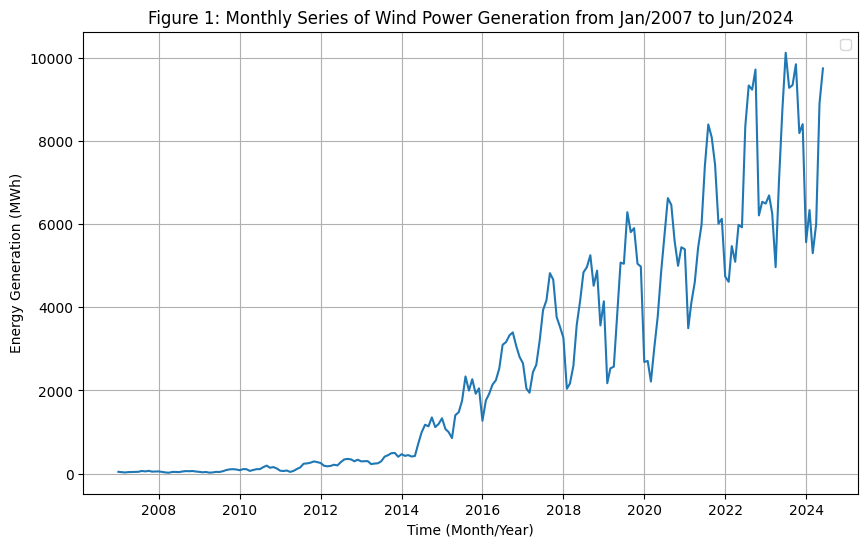

In [264]:
# Plot the training and test sets
plt.figure(figsize=(10, 6))
plt.plot(df['generation_value'])
plt.title('Figure 1: Monthly Series of Wind Power Generation from Jan/2007 to Jun/2024')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

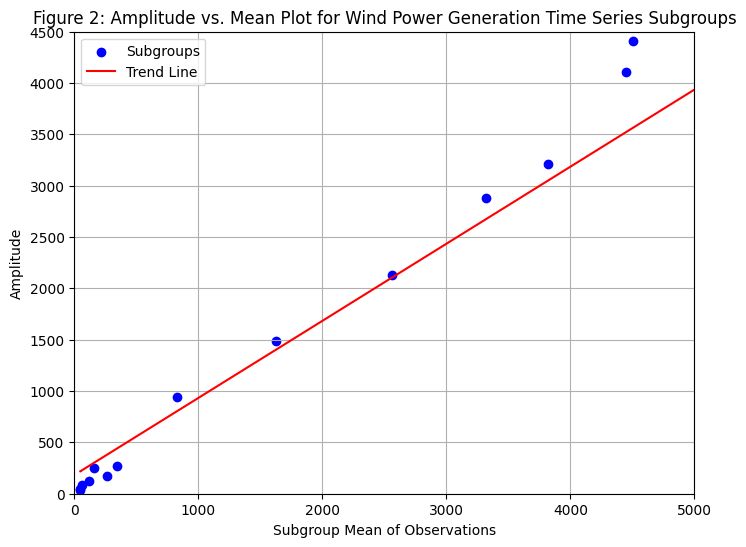

Slope:  0.7507226324259797
P-value: 3.063549414150657e-12


In [265]:
# Divide the time series into subgroups of size N (e.g., 12 months)
N = 12  # Subgroup size (e.g., 12 for annual subgroups)
subgroups = [df['generation_value'][i:i + N] for i in range(0, len(df), N)]

# Calculate the mean and amplitude for each subgroup
mean_values = [group.mean() for group in subgroups if len(group) == N]
amplitude_values = [group.max() - group.min() for group in subgroups if len(group) == N]

# Linear regression for the trend line
slope, intercept, r_value, p_value, std_err = linregress(mean_values, amplitude_values)
line = [slope * xi + intercept for xi in mean_values]

# Plot the amplitude versus mean graph
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, amplitude_values, color='blue', label='Subgroups')
plt.plot(mean_values, line, color='red', label='Trend Line')

# Add titles and labels
plt.title('Figure 2: Amplitude vs. Mean Plot for Wind Power Generation Time Series Subgroups')
plt.xlabel('Subgroup Mean of Observations')
plt.ylabel('Amplitude')

# Adjust axis limits to match the original graph
plt.xlim(0, 5000)
plt.ylim(0, 4500)

# Add grid
plt.grid(True)

# Show legend
plt.legend()

# Display the graph
plt.show()

# Calculate the t-value and the associated p-value
t_value = slope / std_err
d_f = len(mean_values) - 2  # degrees of freedom
p_value = 2 * (1 - t.cdf(np.abs(t_value), d_f))

print('Slope: ', slope)
print(f'P-value: {p_value}')


Estimated lambda value: 0.17061728155134945


<Figure size 1000x600 with 0 Axes>

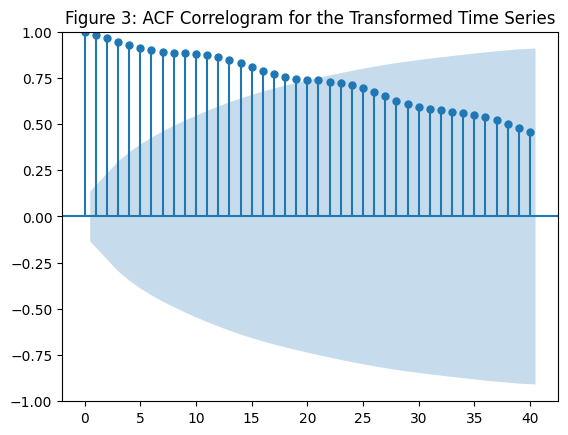

<Figure size 1000x600 with 0 Axes>

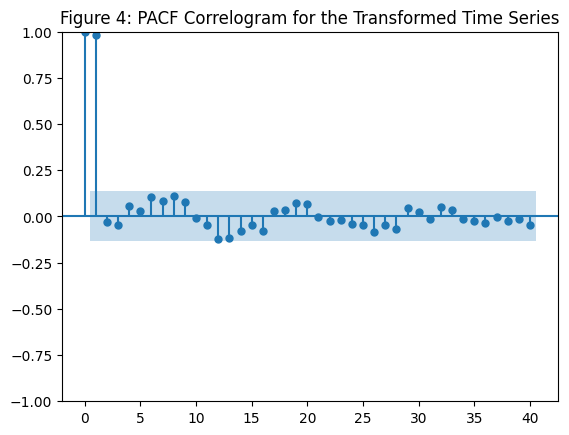

In [266]:
# Apply Box-Cox transformation
df['generation_value_boxcox'], fitted_lambda = boxcox(df['generation_value'])
print(f'Estimated lambda value: {fitted_lambda}')

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 3: ACF Correlogram for the Transformed Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 4: PACF Correlogram for the Transformed Time Series')
plt.show()

In [267]:
# Cox-Stuart test for trend
S, T, half = cox_stuart_test(df['generation_value_boxcox'])
p_value_cox_stuart = binomtest(min(S, T), n=half, p=0.5).pvalue  # Binomial test to calculate the p-value
print(f'Cox-Stuart Test: S={S}, T={T}, p-value={p_value_cox_stuart}')

Cox-Stuart Test: S=0, T=0, p-value=4.930380657631324e-32


In [268]:
# Kruskal-Wallis test for seasonality
# Group data by month to check for seasonality
df['month'] = df.index.month
seasonal_groups = [df[df['month'] == month]['generation_value_boxcox'] for month in range(1, 13)]
H, p_value_kruskal = kruskal(*seasonal_groups)
print(f'Kruskal-Wallis Test: H={H}, p-value={p_value_kruskal}')

Kruskal-Wallis Test: H=5.917959474469058, p-value=0.8787817263639477


<Figure size 1000x600 with 0 Axes>

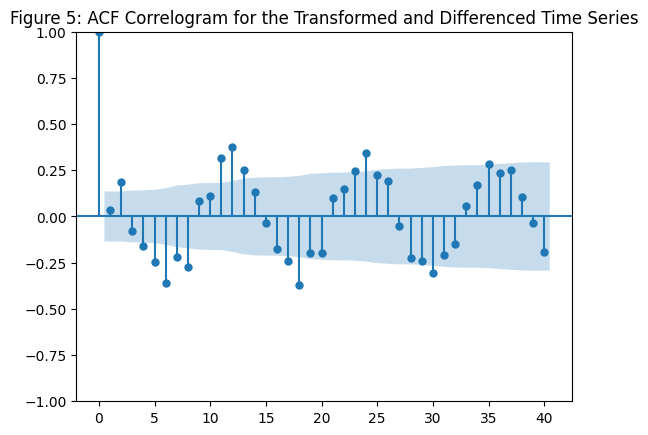

<Figure size 1000x600 with 0 Axes>

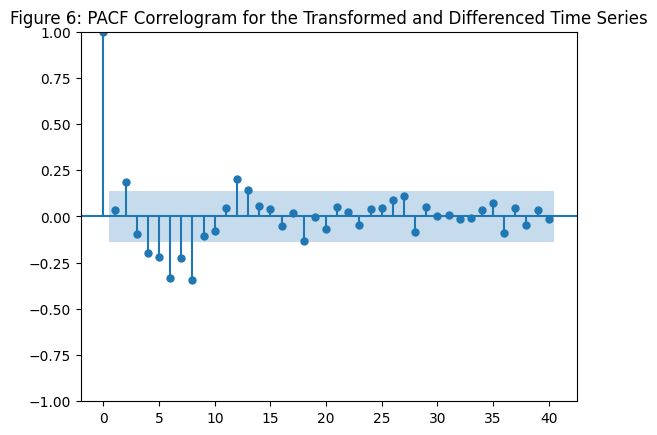

In [269]:
# Apply first-order differencing
df['generation_value_boxcox_diff'] = df['generation_value_boxcox'].diff().dropna()

# Remove N/A values
df = df.dropna(subset=['generation_value_boxcox_diff'])

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 5: ACF Correlogram for Transformed and Differentiated Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 6: PACF Correlogram for the Transformed and Differentiated Time Series')
plt.show()

## SARIMA Model

In [270]:
df

,year,month,val_geracao,generation_value,generation_value_boxcox,generation_value_boxcox_diff
date,,,,,,
2007-02-01,2007,2,36306.070,36.306070,4.956666,-0.383010
2007-03-01,2007,3,28729.610,28.729610,4.533181,-0.423485
2007-04-01,2007,4,37405.240,37.405240,5.011855,0.478674
2007-05-01,2007,5,39726.350,39.726350,5.124116,0.112260
2007-06-01,2007,6,39830.250,39.830250,5.129012,0.004897
...,...,...,...,...,...,...
2024-02-01,2024,2,6339384.520,6339.384520,20.240817,0.573151
2024-03-01,2024,3,5302217.979,5302.217979,19.457186,-0.783631
2024-04-01,2024,4,6003793.409,6003.793409,19.999714,0.542528


In [271]:
# Parameters
p_values = [2, 4, 5, 6, 7, 8]
d = 1
q_values = [2, 4, 5, 6, 7, 8]
P = 1
D = 0
Q = 2
S = 12  # Seasonal order
seed = 42  # Random seed for reproducibility

# Split the data into train and test sets
train = df['2007-01':'2022-12']
test = df['2023-01':'2024-07']

# Store results
results = []

# Suppress specific warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

# Generate all combinations of (p,d,q) and run SARIMA models
for p, q in itertools.product(p_values, q_values):
    if q == S:  # Avoid overlap of seasonal and non-seasonal lags
        continue
    arima_order = (p, d, q)
    seasonal_order = (P, D, Q, S)
    try:
        rmse, aic = evaluate_sarima_model(train['generation_value_boxcox'], test['generation_value_boxcox'], arima_order, seasonal_order, fitted_lambda, seed)
        results.append((arima_order, seasonal_order, rmse, aic))
    except Exception as e:
        results.append((arima_order, seasonal_order, None, None))
        print(f'Error with ARIMA order {arima_order} and seasonal order {seasonal_order}: {e}')

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['ARIMA Order', 'Seasonal Order', 'RMSE', 'AIC'])
results_df = results_df.sort_values(by='RMSE').dropna()

# Display the best models
results_df.head()

,ARIMA Order,Seasonal Order,RMSE,AIC
24,"(7, 1, 2)","(1, 0, 2, 12)",1002.994354,300.429472
5,"(2, 1, 8)","(1, 0, 2, 12)",1044.494717,297.472426
4,"(2, 1, 7)","(1, 0, 2, 12)",1047.731456,296.803581
30,"(8, 1, 2)","(1, 0, 2, 12)",1062.534420,301.503035
0,"(2, 1, 2)","(1, 0, 2, 12)",1064.216903,296.786647


In [272]:
SARIMA_RMSE = results_df.iloc[0]['RMSE']

SARIMA_RMSE

1002.9943538179871

In [273]:
# Fit the chosen SARIMA model
arima_order = (7, 1, 2)
seasonal_order = (1, 0, 2, 12)
model = SARIMAX(train['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecasting
steps = len(test)  # Number of steps for forecasting
predictions = model_fit.forecast(steps=steps)
predictions_inv = inv_boxcox(predictions, fitted_lambda)
predictions_inv

2023-01-01    5484.161324
2023-02-01    4933.583185
2023-03-01    5338.747389
2023-04-01    5739.833027
2023-05-01    6748.769806
2023-06-01    7121.764253
2023-07-01    8951.165640
2023-08-01    9676.244846
2023-09-01    9841.594565
2023-10-01    9436.757321
2023-11-01    7720.840480
2023-12-01    7673.132115
2024-01-01    6820.072467
2024-02-01    5931.086973
2024-03-01    6571.224729
2024-04-01    6751.666202
2024-05-01    7904.003170
2024-06-01    8259.101877
Freq: MS, Name: predicted_mean, dtype: float64

In [274]:
rmse_scorer(test['generation_value'], predictions_inv)

1002.9943538179868

In [275]:
model_resid = model_fit.resid

model_resid

date
2007-02-01    4.956666
2007-03-01    0.492555
2007-04-01   -1.735507
2007-05-01    0.231900
2007-06-01   -0.211023
                ...   
2022-08-01    0.370208
2022-09-01   -0.064543
2022-10-01    0.601780
2022-11-01   -1.288568
2022-12-01   -0.238971
Length: 191, dtype: float64

In [276]:
pred_resid = test['generation_value'] - predictions_inv

pred_resid

date
2023-01-01    1010.557653
2023-02-01    1757.238347
2023-03-01     919.352692
2023-04-01    -773.226515
2023-05-01     275.798384
2023-06-01    1634.275718
2023-07-01    1171.606243
2023-08-01    -397.530057
2023-09-01    -497.068191
2023-10-01     409.117144
2023-11-01     468.775332
2023-12-01     732.127934
2024-01-01   -1254.226277
2024-02-01     408.297547
2024-03-01   -1269.006750
2024-04-01    -747.872793
2024-05-01     995.726637
2024-06-01    1485.588725
dtype: float64

In [277]:
df

,year,month,val_geracao,generation_value,generation_value_boxcox,generation_value_boxcox_diff
date,,,,,,
2007-02-01,2007,2,36306.070,36.306070,4.956666,-0.383010
2007-03-01,2007,3,28729.610,28.729610,4.533181,-0.423485
2007-04-01,2007,4,37405.240,37.405240,5.011855,0.478674
2007-05-01,2007,5,39726.350,39.726350,5.124116,0.112260
2007-06-01,2007,6,39830.250,39.830250,5.129012,0.004897
...,...,...,...,...,...,...
2024-02-01,2024,2,6339384.520,6339.384520,20.240817,0.573151
2024-03-01,2024,3,5302217.979,5302.217979,19.457186,-0.783631
2024-04-01,2024,4,6003793.409,6003.793409,19.999714,0.542528


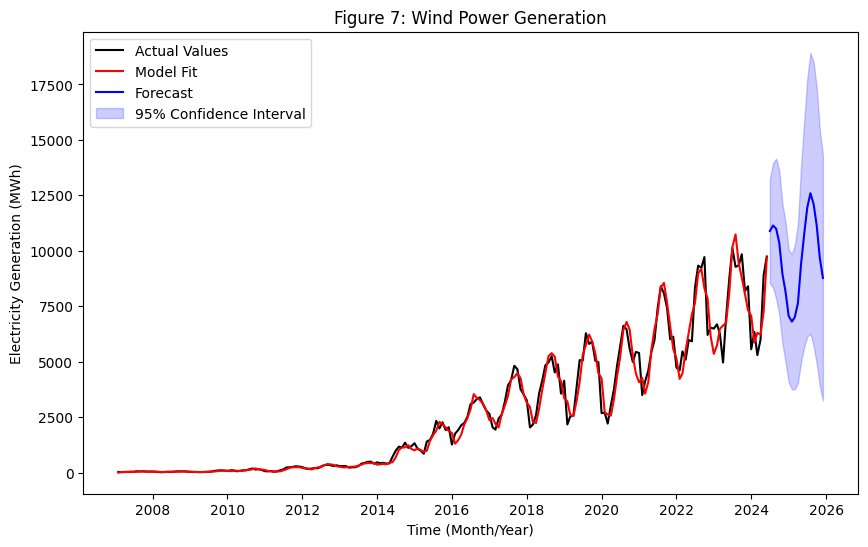

<Figure size 1000x600 with 0 Axes>

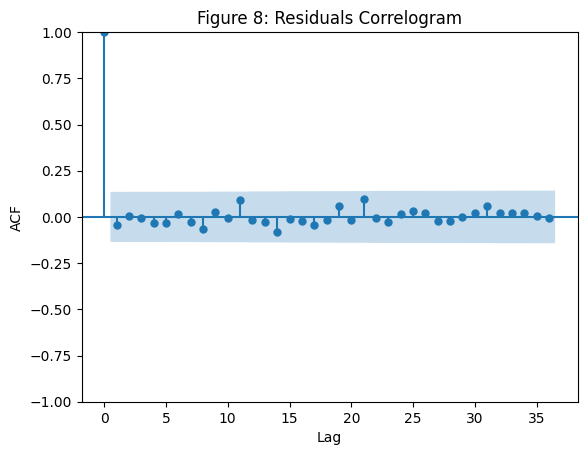

In [278]:
# Fit the chosen SARIMA model
arima_order = (7, 1, 2)
seasonal_order = (1, 0, 2, 12)
model = SARIMAX(df['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecasting
steps = len(test)  # Number of steps for forecasting
predictions_future = model_fit.forecast(steps=steps)
predictions_future_inv = inv_boxcox(predictions_future, fitted_lambda)
df_inv = inv_boxcox(df['generation_value_boxcox'], fitted_lambda)

# Obtain forecasts with confidence intervals
forecast_results = model_fit.get_forecast(steps=steps)
conf_int = forecast_results.conf_int(alpha=0.05)

# Convert the lower and upper bounds back from Box-Cox
conf_int_inv = inv_boxcox(conf_int, fitted_lambda)

# Calculating standard deviations
std_errors = (conf_int_inv.iloc[:, 1] - conf_int_inv.iloc[:, 0]) / (2 * 1.96)

# Generate dates for the forecast period from 2024-08 to 2025-12
last_date = df.index[-1]
dates_forecast = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]

# Convert predictions_future_inv to DataFrame
predictions_future_inv = predictions_future_inv.to_frame(name='Forecast')

# Ensure std_errors is in a DataFrame
std_errors_df = pd.DataFrame(std_errors, index=predictions_future_inv.index, columns=['std_err'])

# Build the forecast_df DataFrame with forecasts and standard errors
forecast_df = pd.concat([predictions_future_inv, std_errors_df], axis=1)

# Calculating the 95% confidence interval
lower_bound = forecast_df['Forecast'] - 1.96 * forecast_df['std_err']
upper_bound = forecast_df['Forecast'] + 1.96 * forecast_df['std_err']

# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['generation_value'], color='black', label='Actual Values')
plt.plot(df.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Model Fit')
plt.plot(predictions_future_inv.index, predictions_future_inv, color='blue', label='Forecast')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

# Correlogram of the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=36)
plt.title('Figure 8: Residuals Correlogram')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# MLP Model

In [279]:
# Read the DataFrame from the CSV file
df = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df = df.loc['2007-01':'2024-07']

# Convert the generation values to thousands
df['generation_value'] = df['val_geracao'] / 1000

# Prepare the data for training
values_mlp = df['generation_value'].values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values_mlp, look_back)

# Split the data into training and testing sets
train_end_index = df.index.get_loc('2023-01-01')
test_start_index = df.index.get_loc('2023-01-01')

trainX, testX = X[:train_end_index - look_back], X[train_end_index - look_back:test_start_index + len(df.loc['2023-01':'2024-07'])]
trainY, testY = y[:train_end_index - look_back], y[train_end_index - look_back:test_start_index + len(df.loc['2023-01':'2024-07'])]

In [280]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score: -530.3277660618303


In [281]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score (RMSE on original scale): -530.3277660618303


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
8,"(100, 100)",0.001,adam,relu,530.327766,359.745339
4,"(150, 150)",0.0001,adam,relu,531.197739,402.403744
2,"(100, 100)",0.0001,adam,relu,539.258314,377.317703
20,"(100, 100)",0.1,adam,relu,547.582169,375.489527
14,"(100, 100)",0.01,adam,relu,560.140236,388.560519


In [282]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore = np.sqrt(mean_squared_error(testY, testPredict))

print(f'Train RMSE: {trainScore}')
print(f'Test RMSE: {testScore}')

Train RMSE: 106.53949767628616
Test RMSE: 1607.606192103449


In [283]:
MLP_RMSE = testScore
MLP_RMSE

1607.606192103449

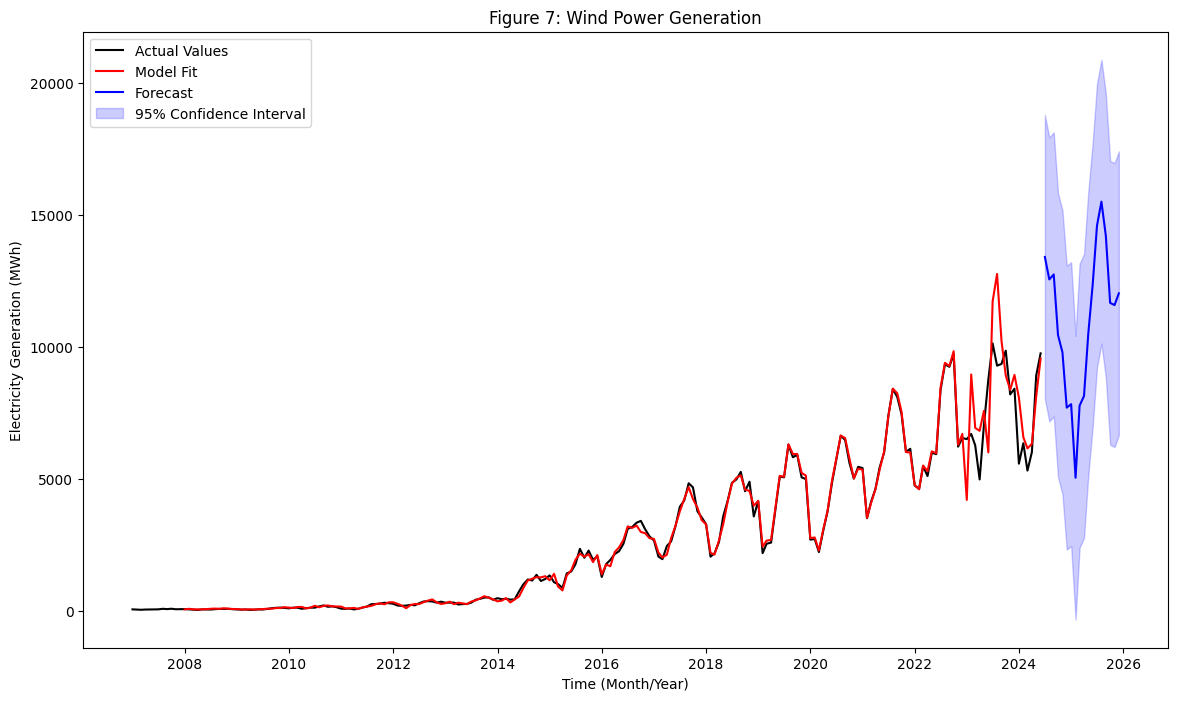

In [284]:
# Make future predictions from July 2024 to December 2025
future_steps = 18  # Number of months from July 2024 to December 2025
last_window = values_mlp[-look_back:].reshape(1, -1)

future_predictions = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions = np.array(future_predictions).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2024-07-01', periods=future_steps, freq='MS')
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['generation_value'])

# Calculate confidence intervals
prediction_intervals = []
std_future = np.std(future_predictions)
for pred in future_predictions:
    lower_bound = pred - 1.96 * std_future  # 95% confidence interval lower bound
    upper_bound = pred + 1.96 * std_future  # 95% confidence interval upper bound
    prediction_intervals.append((lower_bound[0], upper_bound[0]))

prediction_intervals = np.array(prediction_intervals)

# Combine training and test predictions to create a continuous series
all_predictions = np.empty_like(values_mlp)
all_predictions[:, :] = np.nan

# Adjust training predictions for plotting
trainPredictPlot = np.empty_like(values_mlp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Adjust test predictions for plotting
testPredictPlot = np.empty_like(values_mlp)
testPredictPlot[:, :] = np.nan
test_start = len(trainPredictPlot) - len(testPredict)

testPredictPlot[test_start:test_start + len(testPredict), :] = testPredict

# Combine both predictions into all_predictions
all_predictions[look_back:len(trainPredict) + look_back] = trainPredict
all_predictions[test_start:test_start + len(testPredict)] = testPredict


# Plot actual values, model fit, forecast, and confidence intervals
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['generation_value'], label='Actual Values', color='black')
plt.plot(df.index[look_back:len(all_predictions)], all_predictions[look_back:], label='Model Fit', color='red')
plt.plot(future_df.index, future_predictions, label='Forecast', color='blue')
plt.fill_between(future_df.index, prediction_intervals[:, 0], prediction_intervals[:, 1], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.title('Figure 7: Wind Power Generation')
plt.legend()
plt.show()

## SARIMA MLP Model

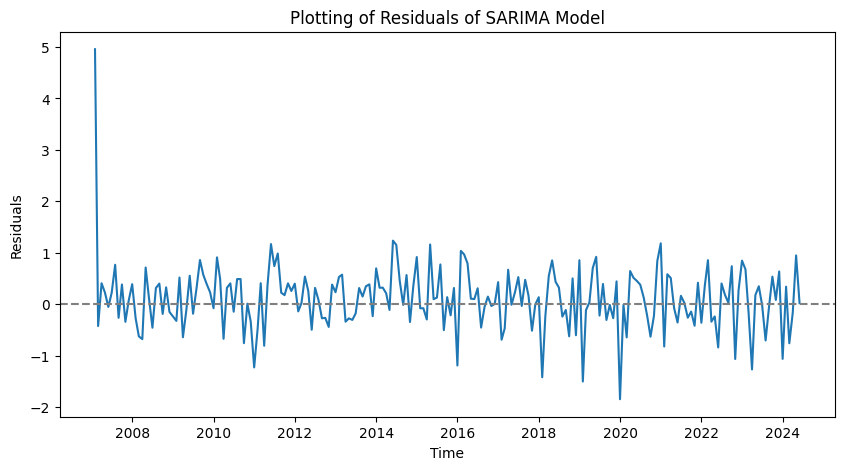

In [310]:
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Plotting of Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

In [336]:
values = residuals.values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values, look_back)

# Split the data into training and testing sets
train_end_index = df.index.get_loc('2022-12-01')
test_start_index = df.index.get_loc('2022-11-01')

trainX, testX = X[:train_end_index], X[train_end_index - look_back:train_end_index + len(df.loc['2023-01':'2024-07'])]
trainY, testY = y[:train_end_index], y[train_end_index - look_back:train_end_index + len(df.loc['2023-01':'2024-07'])]

In [337]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'solver': 'sgd'}
Best score: -0.5590311273240826


In [313]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'solver': 'sgd'}
Best score (RMSE on original scale): -0.5590311273240826


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
19,"(100, 50)",0.1,sgd,relu,0.559031,0.087310
13,"(100, 50)",0.01,sgd,relu,0.559221,0.087170
7,"(100, 50)",0.001,sgd,relu,0.559243,0.087153
1,"(100, 50)",0.0001,sgd,relu,0.559246,0.087152
23,"(150, 150)",0.1,sgd,relu,0.572078,0.073071


In [314]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

In [315]:
index_dates = pd.date_range(start='2023-01-01', periods=len(testPredict), freq='MS') 

In [316]:
testPredict_df = pd.DataFrame(testPredict, columns=['Predictions'], index=index_dates)

In [317]:
predictions_inv_df = pd.DataFrame(predictions_inv)

predictions_inv_df

,predicted_mean
2023-01-01,5484.161324
2023-02-01,4933.583185
2023-03-01,5338.747389
2023-04-01,5739.833027
2023-05-01,6748.769806
2023-06-01,7121.764253
2023-07-01,8951.165640
2023-08-01,9676.244846
2023-09-01,9841.594565
2023-10-01,9436.757321


In [318]:
testPredict_df

,Predictions
2023-01-01,0.145991
2023-02-01,0.096839
2023-03-01,0.023995
2023-04-01,0.005014
2023-05-01,0.337848
2023-06-01,0.223967
2023-07-01,0.181347
2023-08-01,0.065585
2023-09-01,0.203454
2023-10-01,0.196336


In [338]:
start_weight = 0
end_weight = 5000
step = 1

best_rmse = np.inf 
best_weight = None

# Loop for possible weights
for weight in np.arange(start_weight, end_weight + step, step):
    # Calculate combined predictions
    combined_predictions = predictions_inv_df['predicted_mean'] + weight * testPredict_df['Predictions']

    # Calculate RMSE
    current_rmse = rmse_scorer(test['generation_value'], combined_predictions)

    # Verify best weight
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_weight = weight

SARIMA_MLP_RMSE = best_rmse

print(f"Best Weight: {best_weight}")
print(f"Best RMSE: {best_rmse}")

Best Weight: 1836
Best RMSE: 941.4501284758521


In [328]:
predictions_future_inv

,Forecast
2024-07-01,10894.296398
2024-08-01,11143.032758
2024-09-01,10991.895405
2024-10-01,10353.570946
2024-11-01,8950.114764
2024-12-01,8156.439212
2025-01-01,7056.380509
2025-02-01,6809.411215
2025-03-01,7005.939690
2025-04-01,7639.390662


In [332]:
# Make future predictions from July 2024 to December 2025
future_steps = 18  # Number of months from July 2024 to December 2025
last_window = values[-look_back:].reshape(1, -1)

future_predictions_resid = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions_resid.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions_resid = np.array(future_predictions_resid).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2024-07-01', periods=future_steps, freq='MS')
future_df_resid = pd.DataFrame(data=future_predictions_resid, index=future_dates, columns=['generation_value'])

future_df_resid

,generation_value
2024-07-01,-0.050215
2024-08-01,0.181423
2024-09-01,0.135107
2024-10-01,0.038050
2024-11-01,0.126856
2024-12-01,0.309398
2025-01-01,0.182269
2025-02-01,0.052786
2025-03-01,0.022726
2025-04-01,0.094474


In [333]:
combined_predictions = predictions_future_inv['Forecast'] + best_weight * future_df_resid['generation_value']

combined_predictions

2024-07-01    10802.102025
2024-08-01    11476.124842
2024-09-01    11239.952692
2024-10-01    10423.430188
2024-11-01     9183.023011
2024-12-01     8724.493483
2025-01-01     7391.025901
2025-02-01     6906.325779
2025-03-01     7047.664380
2025-04-01     7812.844344
2025-05-01     9568.568200
2025-06-01    10752.590502
2025-07-01    12016.606810
2025-08-01    12674.114920
2025-09-01    12174.025676
2025-10-01    11259.816737
2025-11-01     9829.588134
2025-12-01     8943.125914
Freq: MS, dtype: float64

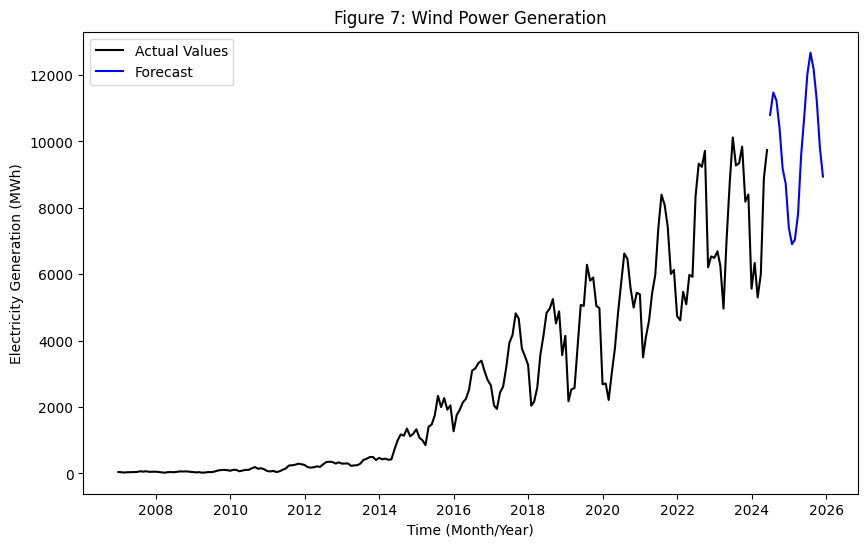

In [334]:
# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['generation_value'], color='black', label='Actual Values')
#plt.plot(df.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Model Fit')
plt.plot(combined_predictions.index, combined_predictions, color='blue', label='Forecast')
#plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

In [339]:
data = {
    "Model": [ "MLP", "SARIMA", "SARIMA-MLP"],
    "RMSE": [MLP_RMSE, SARIMA_RMSE, SARIMA_MLP_RMSE]
}

rmse_df = pd.DataFrame(data)
rmse_df

,Model,RMSE
0,MLP,1607.606192
1,SARIMA,1002.994354
2,SARIMA-MLP,941.450128
